In [1]:
import os
import sys
import gc
# assuming data, models, engine in flicc directory:
flicc_path = os.path.realpath("__file__").split('grid_search')[0]
sys.path.append(flicc_path)
import torch
from data import ClimateDataset
from models import ClassificationModel
from engine import Engine

In [2]:
model_checkpoint='bert-base-uncased'

In [3]:
results = {'test_acc':[],
           'test_f1':[],
           'eval_acc':[],
           'eval_f1':[],
           'wd':[]}

In [4]:
g = 2
lr = 1.0e-5
weight_decay = [0.1, 0.01]

for wd in weight_decay:
    print(f'Grid search {model_checkpoint}, learning rate {lr}, focal loss gamma {g}, weight decay {wd}')
    data = ClimateDataset(model_to_train=2,model_checkpoint=model_checkpoint,dataset_url=flicc_path,batch_size=16)
    data.setup_dataloaders()
    model = ClassificationModel(model_checkpoint=data.model_checkpoint,num_labels=data.num_labels)
    trainer = Engine(epochs=30,labels=data.labels)
    trainer.model = model.model
    trainer.dataset_encoded = data.dataset_encoded
    test_acc, test_f1, eval_acc, eval_f1 = trainer.run(lr=lr,
                                                       wd=wd,
                                                       train_dataloader=data.train_dataloader,
                                                       eval_dataloader=data.eval_dataloader,
                                                       test_dataloader=data.test_dataloader,
                                                       focalloss=True,
                                                       accumulation_steps=2,
                                                       gamma=g,
                                                       early_stop=3)
    results['test_acc'].append(test_acc)
    results['test_f1'].append(test_f1)
    results['eval_acc'].append(eval_acc)
    results['eval_f1'].append(eval_f1)
    results['wd'].append(wd)
    print('### '*10)
    print(results)
    print('### '*10)
    with torch.no_grad():
        torch.cuda.empty_cache()
    del data, model, trainer, test_acc, test_f1, eval_acc, eval_f1
    gc.collect()

Grid search bert-base-uncased, learning rate 1e-05, focal loss gamma 2, weight decay 0.1


Filter:   0%|          | 0/1796 [00:00<?, ? examples/s]

Filter:   0%|          | 0/256 [00:00<?, ? examples/s]

Filter:   0%|          | 0/457 [00:00<?, ? examples/s]

Map:   0%|          | 0/472 [00:00<?, ? examples/s]

Map:   0%|          | 0/67 [00:00<?, ? examples/s]

Map:   0%|          | 0/119 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


1 / 30: Train Loss:	0.7399	Val Loss:	1.0094	Accuracy:	0.6050	F1:	0.5941
2 / 30: Train Loss:	0.5820	Val Loss:	0.9315	Accuracy:	0.6555	F1:	0.6271
3 / 30: Train Loss:	0.4998	Val Loss:	0.8293	Accuracy:	0.6807	F1:	0.6653
4 / 30: Train Loss:	0.3972	Val Loss:	0.7892	Accuracy:	0.6975	F1:	0.6789
5 / 30: Train Loss:	0.3194	Val Loss:	0.7487	Accuracy:	0.7059	F1:	0.6886
6 / 30: Train Loss:	0.2501	Val Loss:	0.7435	Accuracy:	0.6807	F1:	0.6579
7 / 30: Train Loss:	0.1990	Val Loss:	0.6549	Accuracy:	0.7563	F1:	0.7438
8 / 30: Train Loss:	0.1694	Val Loss:	0.6268	Accuracy:	0.7563	F1:	0.7516
9 / 30: Train Loss:	0.1379	Val Loss:	0.6734	Accuracy:	0.7059	F1:	0.7046
10 / 30: Train Loss:	0.1158	Val Loss:	0.6427	Accuracy:	0.7479	F1:	0.7343
11 / 30: Train Loss:	0.0718	Val Loss:	0.6113	Accuracy:	0.7647	F1:	0.7563
12 / 30: Train Loss:	0.0479	Val Loss:	0.5733	Accuracy:	0.7815	F1:	0.7740
13 / 30: Train Loss:	0.0333	Val Loss:	0.5907	Accuracy:	0.7899	F1:	0.7824
14 / 30: Train Loss:	0.0269	Val Loss:	0.5956	Accuracy:	0.798

Map:   0%|          | 0/67 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


1 / 30: Train Loss:	0.7399	Val Loss:	1.0094	Accuracy:	0.6050	F1:	0.5941
2 / 30: Train Loss:	0.5820	Val Loss:	0.9314	Accuracy:	0.6555	F1:	0.6271
3 / 30: Train Loss:	0.5001	Val Loss:	0.8288	Accuracy:	0.6891	F1:	0.6727
4 / 30: Train Loss:	0.4042	Val Loss:	0.8105	Accuracy:	0.6975	F1:	0.6768
5 / 30: Train Loss:	0.3252	Val Loss:	0.7684	Accuracy:	0.6807	F1:	0.6564
6 / 30: Train Loss:	0.2640	Val Loss:	0.7195	Accuracy:	0.7395	F1:	0.7241
7 / 30: Train Loss:	0.2091	Val Loss:	0.6447	Accuracy:	0.7731	F1:	0.7678
8 / 30: Train Loss:	0.1740	Val Loss:	0.6471	Accuracy:	0.7311	F1:	0.7299
9 / 30: Train Loss:	0.1370	Val Loss:	0.6176	Accuracy:	0.7647	F1:	0.7572
10 / 30: Train Loss:	0.1002	Val Loss:	0.6602	Accuracy:	0.7479	F1:	0.7366
No improvement for 3 epochs. Stopping early.
best (higgest macro f1-score) val results:
                    precision    recall  f1-score   support

 misrepresentation       0.72      0.74      0.73        38
oversimplification       0.81      0.69      0.75        36
slothful i

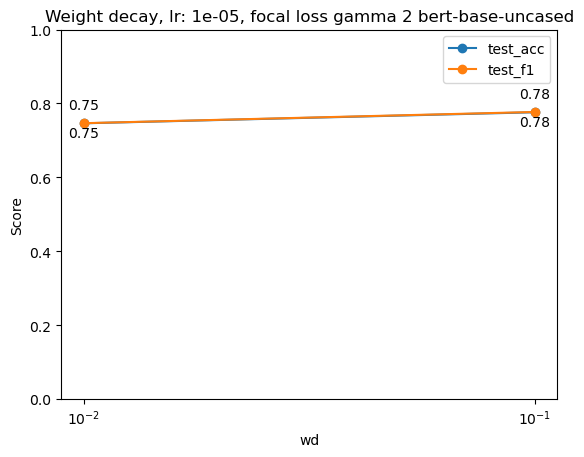

In [5]:
Engine.plot_grid_search(df=results,
                        title=f'Weight decay, lr: {lr}, focal loss gamma {g} {model_checkpoint}',
                        column='wd',
                        sci_format=True)

In [6]:
%reset -f